# Marketing Case Study

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler 
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

## Customer Segmentation

A key objective is to create a predictive model which allows the company to maximize the profits of the next marketing campaign.

In [9]:
# load data
with open("processed_data.csv", "r") as f:
    seg_data = pd.read_csv(f)

seg_data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,Response,Complain,Country,Age,Length_customer_yrs,Dependents,Total_Spent,Tot_Num_Purchases,Spent per purchase,Total_Accepted_Camp
0,1970,Graduation,Divorced,84835.0,0,0,0,15.88,8.74,31.85,...,1,0,SP,52,8.04,0,1190,14.0,85.00,0
1,1961,Graduation,Single,57091.0,0,0,0,80.42,0.87,11.09,...,1,0,CA,61,8.04,0,577,17.0,33.94,1
2,1958,Graduation,Couple,67267.0,0,1,0,53.39,4.38,23.51,...,0,0,US,64,8.13,1,251,10.0,25.10,0
3,1967,Graduation,Couple,32474.0,1,1,0,90.91,0.00,9.09,...,0,0,AUS,55,8.14,2,11,3.0,3.67,0
4,1989,Graduation,Single,21474.0,1,0,0,6.59,17.58,26.37,...,1,0,SP,33,8.23,1,91,6.0,15.17,1


In [10]:
seg_data.drop(columns=["Response"], inplace=True)

In [11]:
seg_data.columns.to_list()

['Year_Birth',
 'Education',
 'Marital_Status',
 'Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Country',
 'Age',
 'Length_customer_yrs',
 'Dependents',
 'Total_Spent',
 'Tot_Num_Purchases',
 'Spent per purchase',
 'Total_Accepted_Camp']

In [12]:
seg_df = pd.DataFrame(data[seg_cols])

In [13]:
seg_df.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebVisitsMonth,Country,Age,Length_customer_yrs,Dependents,Total_Spent,Tot_Num_Purchases,Total_Accepted_Camp
0,Graduation,Divorced,84835.0,0,15.88,8.74,31.85,9.33,15.88,18.32,1,1,SP,52,8.04,0,1190,14.0,0
1,Graduation,Single,57091.0,0,80.42,0.87,11.09,1.21,0.00,6.41,1,5,CA,61,8.04,0,577,17.0,1
2,Graduation,Couple,67267.0,0,53.39,4.38,23.51,5.98,0.80,11.95,1,2,US,64,8.13,1,251,10.0,0
3,Graduation,Couple,32474.0,0,90.91,0.00,9.09,0.00,0.00,0.00,1,7,AUS,55,8.14,2,11,3.0,0
4,Graduation,Single,21474.0,0,6.59,17.58,26.37,12.09,0.00,37.36,2,7,SP,33,8.23,1,91,6.0,1


In [14]:
seg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2188 entries, 0 to 2187
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2188 non-null   object 
 1   Marital_Status       2188 non-null   object 
 2   Income               2188 non-null   float64
 3   Recency              2188 non-null   int64  
 4   MntWines             2188 non-null   float64
 5   MntFruits            2188 non-null   float64
 6   MntMeatProducts      2188 non-null   float64
 7   MntFishProducts      2188 non-null   float64
 8   MntSweetProducts     2188 non-null   float64
 9   MntGoldProds         2188 non-null   float64
 10  NumDealsPurchases    2188 non-null   int64  
 11  NumWebVisitsMonth    2188 non-null   int64  
 12  Country              2188 non-null   object 
 13  Age                  2188 non-null   int64  
 14  Length_customer_yrs  2188 non-null   float64
 15  Dependents           2188 non-null   i

In [15]:
del data

## Pre-Processing Data

Performing customer segmentation using machine learning requires some preprocessing of the data.
- First, if the data are skewed, then the data needs to be transformed
- Next, there are a few categorical features that need to be encoded
- Finally, the data are normalized

Use sklearn pipeline to streamline the pre-processing of data needed before modeling.

https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py

In [16]:
# scale numerical features
num_features = seg_df.select_dtypes(exclude="object").columns
num_scaler = Pipeline(
    steps=[('scaler', MinMaxScaler())]
)

# nominal categorical data
nom_cat = ['Marital_Status', 'Country']
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

# ordered categorical data
ord_cat = ['Education']
ord_encoder = OrdinalEncoder()

preprocessor = ColumnTransformer(
    transformers= [
        ("scaler", num_scaler, num_features),
        ("nom", one_hot_encoder, nom_cat),
        ("ord", ord_encoder, ord_cat)
    ]
)

In [17]:
# preprocessor

In [18]:
prep_data = preprocessor.fit_transform(seg_df)

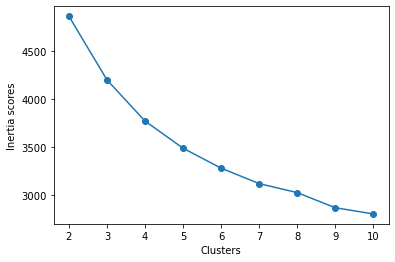

In [19]:
inertia_scores = []
silhouette_scores = []

for n in range(2, 11):
    kmeans = KMeans(n_clusters = n, init="k-means++", random_state =43)
    kmeans.fit(prep_data)
    inertia_scores.append(kmeans.inertia_)
    sscore = silhouette_score(prep_data, kmeans.labels_)
    silhouette_scores.append(sscore)

plt.plot(range(2, 11), inertia_scores, marker = "o")
plt.xlabel("Clusters")
plt.ylabel("Inertia scores")
plt.show()

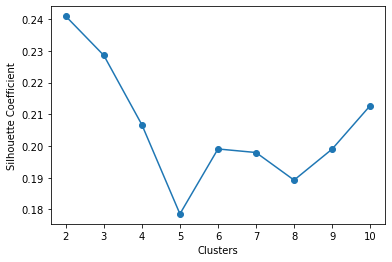

In [20]:
plt.plot(range(2, 11), silhouette_scores, marker = "o")
plt.xticks(range(2,11))
plt.xlabel("Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Another method to used evaluate what value of k to use is with the kneed module.

In [21]:
from kneed import KneeLocator

kl = KneeLocator(
    range(2, 11), inertia_scores, curve="convex", direction="decreasing"
)

In [22]:
kl.elbow

5

## Modeling

Add KMeans model to pipeline.

We will also use PCA to reduce the number of dimensions to 2

In [23]:
from sklearn.decomposition import PCA

reduce_dim = Pipeline(
    [('reduce_dim', 
        PCA(n_components=2, random_state=42)
        )])

In [24]:
n_clusters = 5

segmenter = Pipeline(
    [("kmeans",
        KMeans(
            n_clusters=n_clusters,
            init="k-means++",
            n_init=10,
            max_iter=300,
            random_state=3
        ))])

In [25]:
clf_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("reduce_dim", reduce_dim),
        ("segmenter", segmenter)
        ])

In [26]:
kmeans = clf_pipe.fit(seg_df)
preds = kmeans.predict(seg_df)
seg_df['Cluster'] = preds + 1

In [27]:
# counts of clusters with PCA
seg_df['Cluster'].value_counts()

1    703
2    544
4    415
5    296
3    230
Name: Cluster, dtype: int64

In [28]:
# count of clusters before PCA
# seg_df['Cluster'].value_counts()

In [29]:
pcadf = pd.DataFrame(
    clf_pipe[:-1].transform(seg_df),
    columns=["component_1", "component_2"])

pcadf["predicted_cluster"] = clf_pipe["segmenter"]["kmeans"].labels_

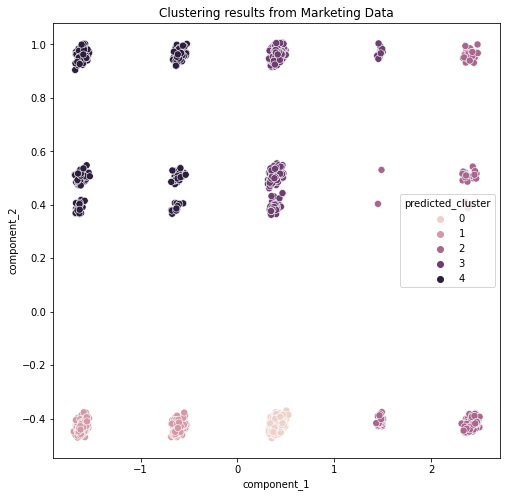

In [30]:
plt.figure(figsize=(8,8))
g = sns.scatterplot(
    "component_1", "component_2",
    data=pcadf,
    hue="predicted_cluster",
    s=50
)
g.set_title("Clustering results from Marketing Data")
plt.show()

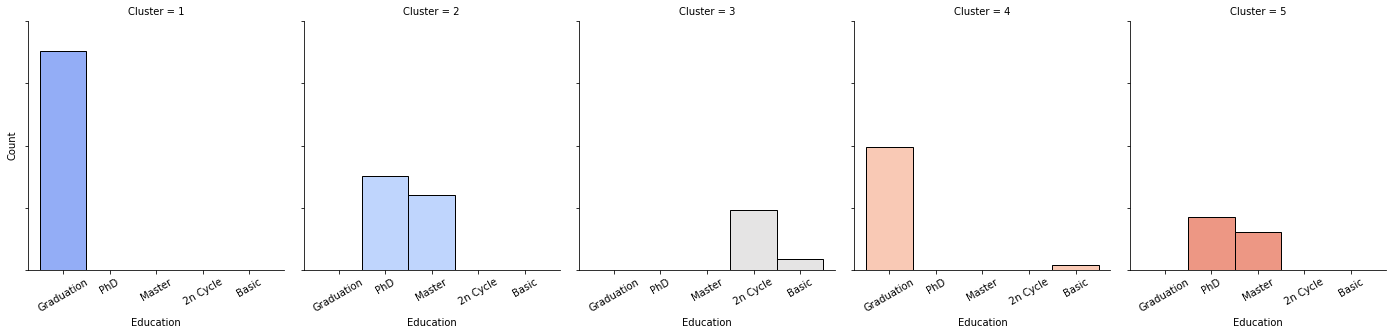

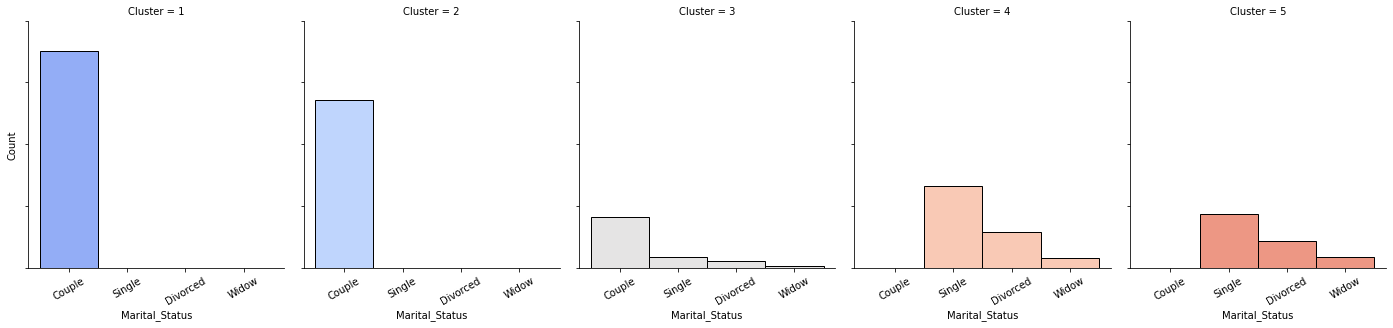

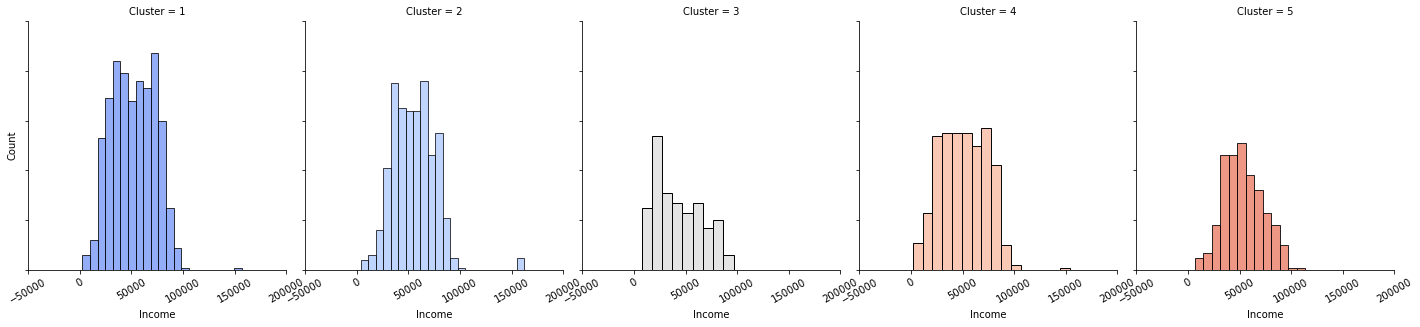

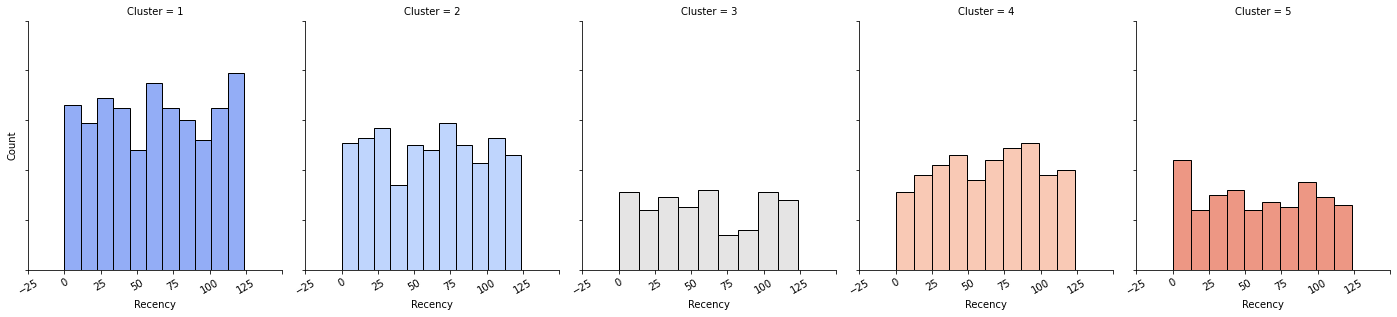

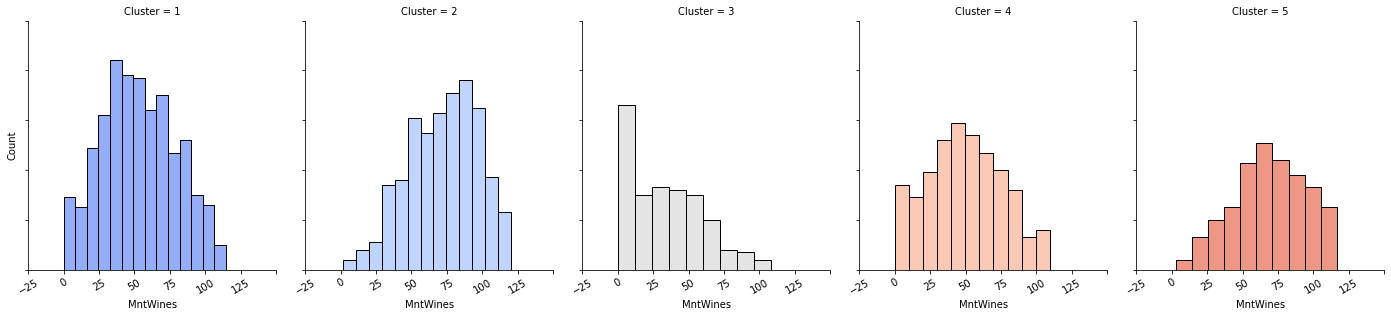

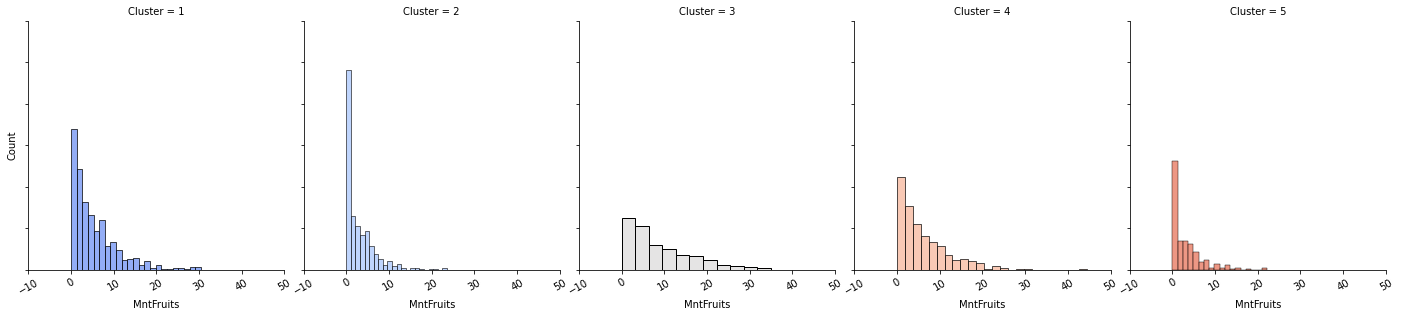

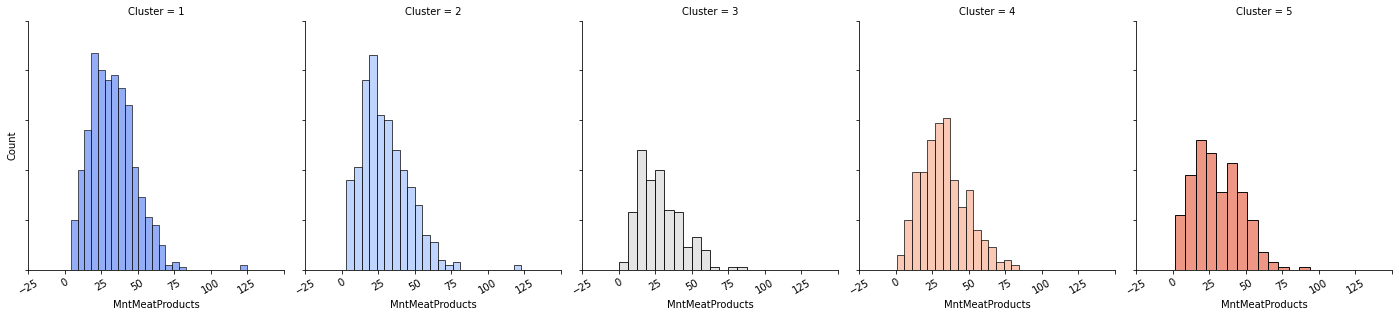

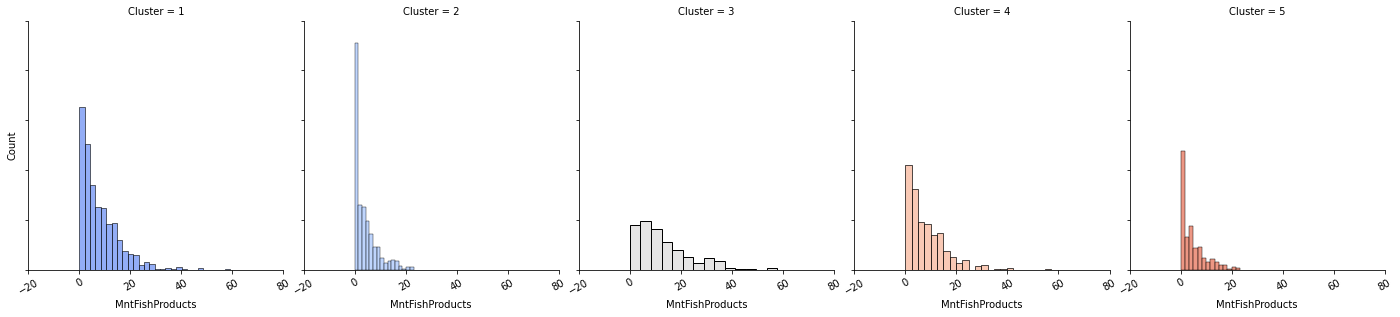

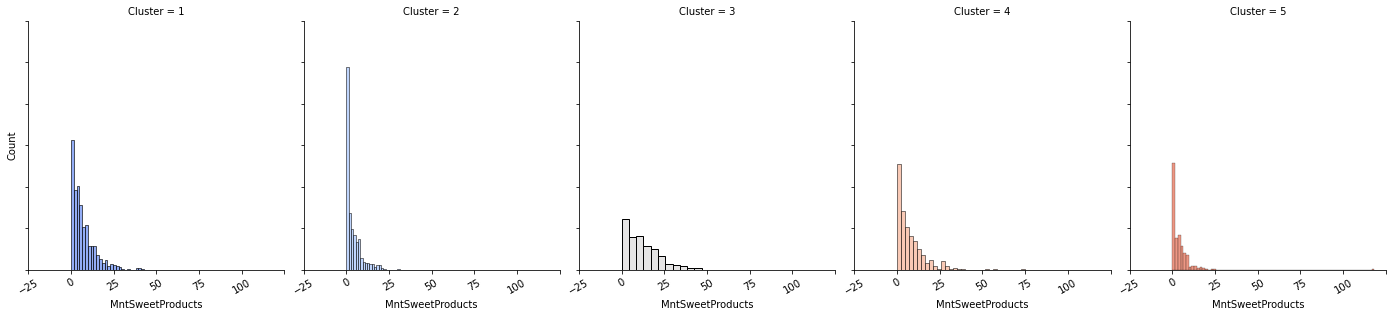

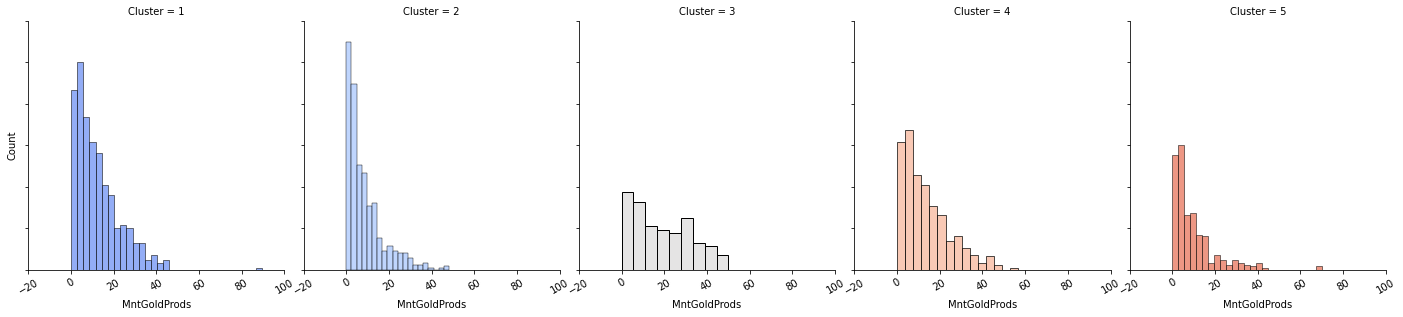

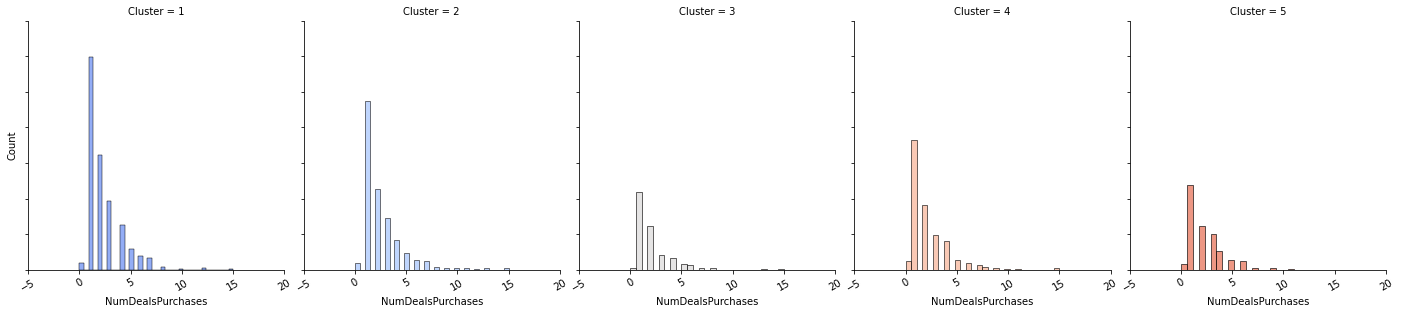

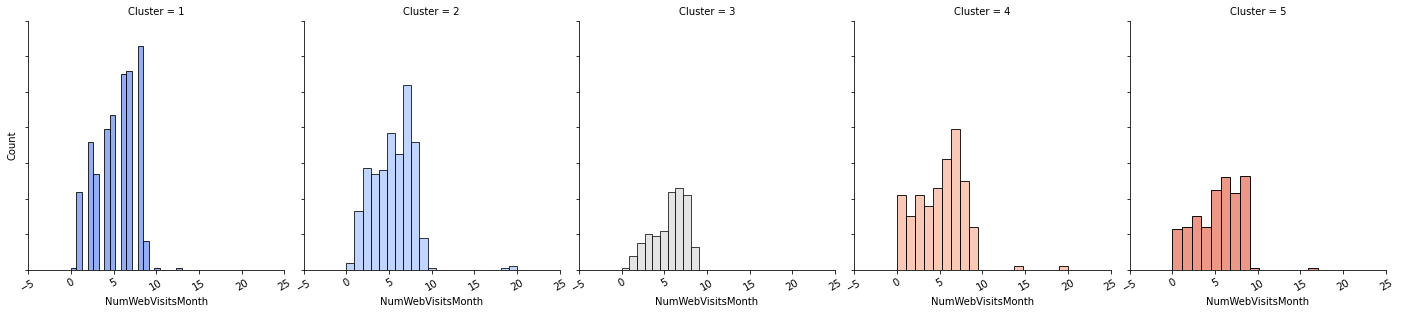

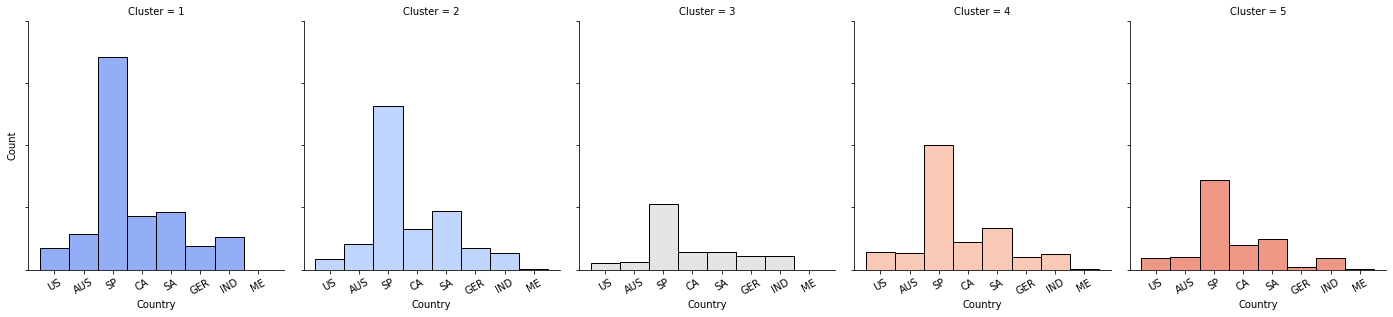

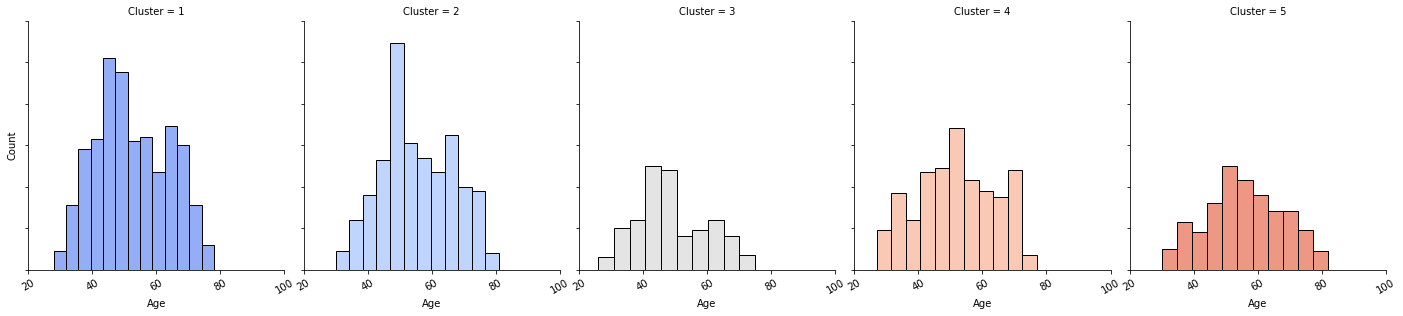

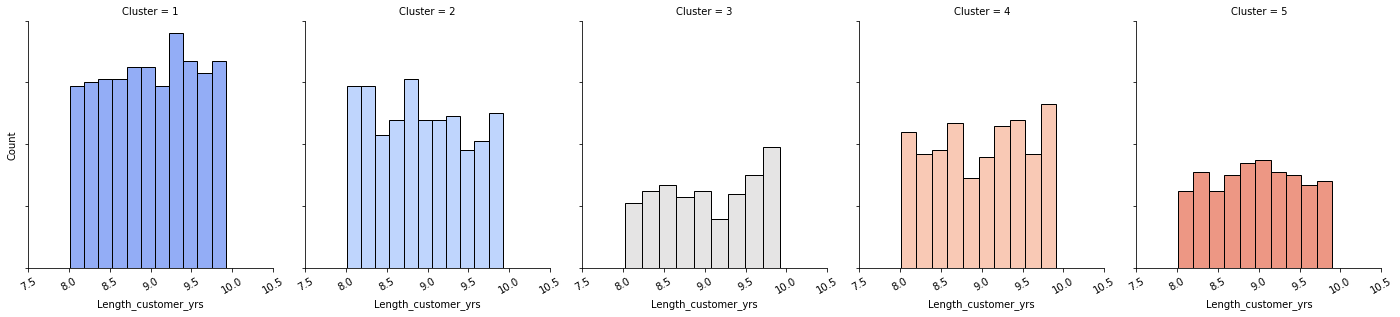

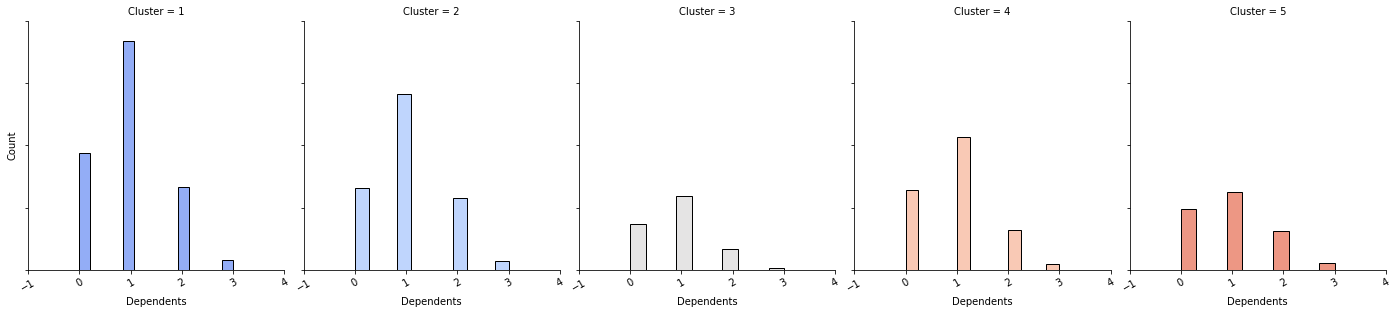

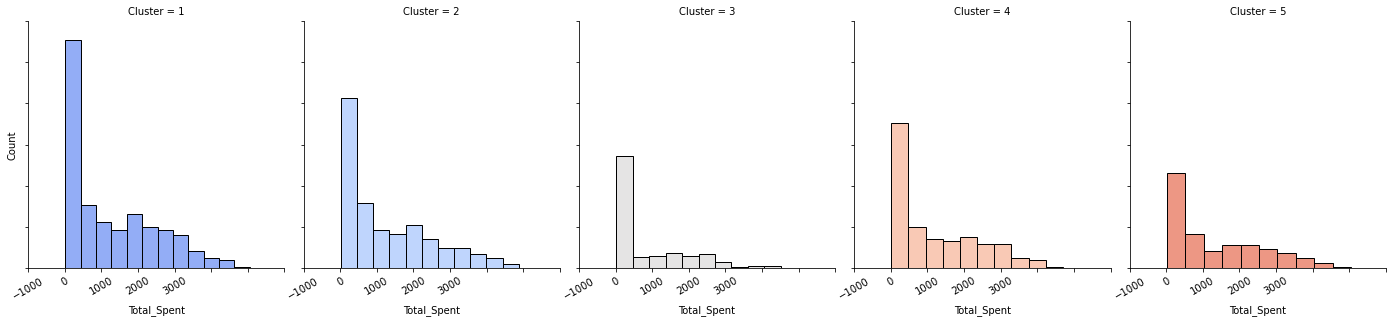

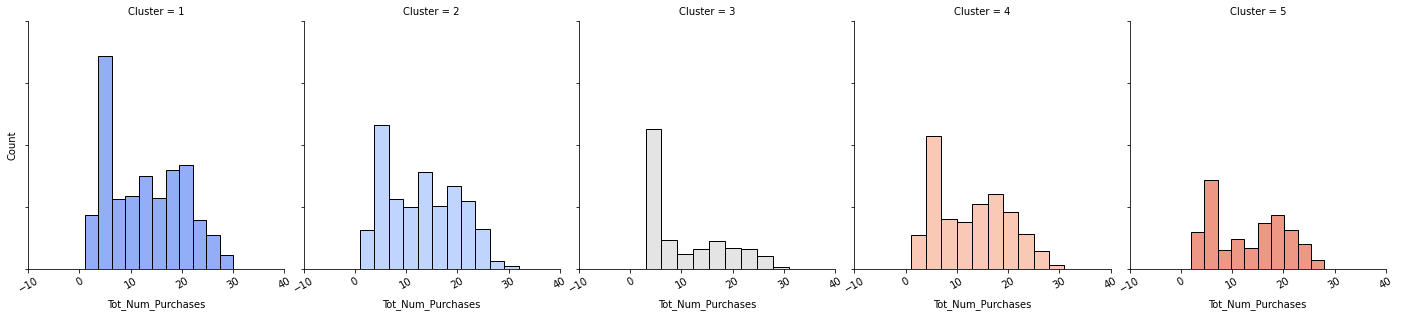

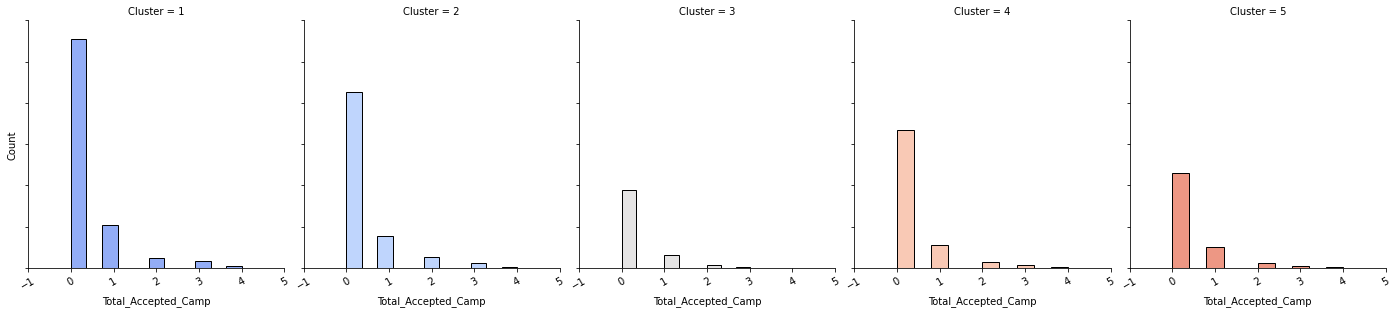

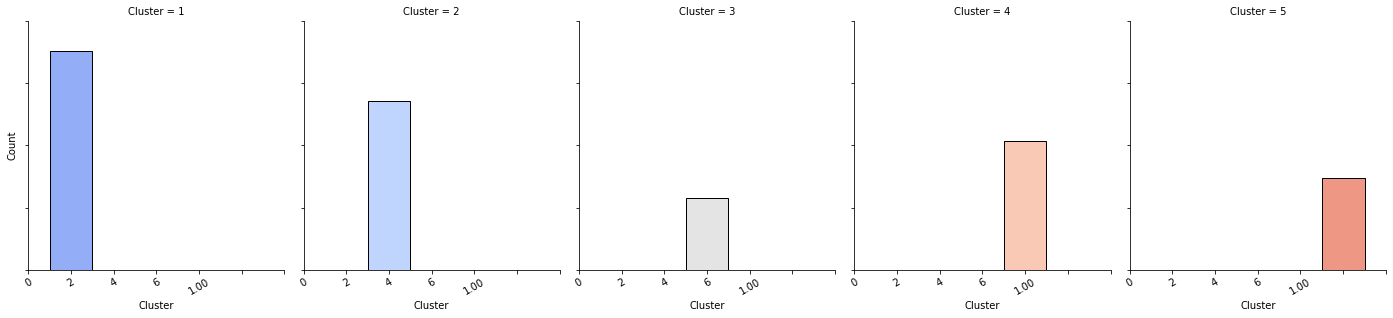

In [31]:
for i in seg_df:
    g = sns.FacetGrid(seg_df, col = "Cluster", hue = "Cluster", palette = "coolwarm", sharey=True,sharex=True)
    g.map(sns.histplot,i) 
    g.set_xticklabels(rotation=30)
    g.set_yticklabels()
    g.fig.set_figheight(5)
    g.fig.set_figwidth(20)

### Summary of Cluster characteristics

Clusters 1 and 2 represent all the customers who are in a relationship.

Cluster 1:
All customers have a Graduation level of education.
All customers are in a relationship
Spends more on meat products than cluster 2.

Cluster 2:
Customers all have either a PhD or Masters degree.
All customers are in a relationship
Spends the most amount of money on wine.
Least likely to visit the website.
These indicate that called , very similar to cluster 1.


Cluster 3:
Customers have either a basic or second-cycle education level.
This cluster has a mix of all the marital statuses.
The average income of this cluster is the lowest.
Purchase the least amount of wine and meat, but the most on fish, sweets, and gold products.
Least likely to make a purchase with a discount.
Visits the website most frequently.
Youngest demographic
Spent the least and also made the least number of purchases.


Cluster 4:
Customers have a basic or graduation-cycle education level
Customers are not currently in a relationship
Overall, very similar to Cluster 5.
Spends more on meat than cluster 5.


Cluster 5:
Customers all have either a PhD or Masters degree.
Customers are not currently in a relationship
Spends the second most on wine.
Older customers.
Spent the most and also has the most number of purchases.

In [32]:
accepted = pd.DataFrame(seg_df.groupby('Cluster')['Total_Accepted_Camp'].value_counts())
accepted.groupby(level=0).transform(lambda x: (x / x.sum()).round(2))

Total_Accepted_Camp
Cluster Total_Accepted_Camp                     
1       0                                   0.79
        1                                   0.15
        2                                   0.03
        3                                   0.02
        4                                   0.01
2       0                                   0.78
        1                                   0.14
        2                                   0.05
        3                                   0.02
        4                                   0.00
3       0                                   0.82
        1                                   0.13
        2                                   0.03
        3                                   0.01
4       0                                   0.81
        1                                   0.13
        2                                   0.03
        3                                   0.02
        4                                   0.01
5       0                                   0.77
        1                                   0.17
        2                                   0.04
        3                                   0.01
        4                                   0.01

In [33]:
discounts = pd.DataFrame(seg_df.groupby('Cluster')['NumDealsPurchases'].value_counts())
discounts.groupby(level=0).transform(lambda x: (x / x.sum()).round(2))

NumDealsPurchases
Cluster NumDealsPurchases                   
1       1                               0.43
        2                               0.23
        3                               0.14
        4                               0.09
        5                               0.04
...                                      ...
5       6                               0.04
        0                               0.03
        7                               0.01
        9                               0.01
        11                              0.00

[61 rows x 1 columns]

## Average Value of Features

In [34]:
def plot_cluster_feat(i: str):
    return seg_df.groupby('Cluster')[i].agg(['mean', 'median'])

In [36]:
# group_income = seg_df.groupby('Cluster')['Income'].agg(['mean', 'median'])
plot_cluster_feat('Income')

,mean,median
Cluster,,
1,52097.735420,51651.0
2,55186.625000,54444.0
3,43498.782609,38721.5
4,51214.604819,51411.0
5,53500.648649,51411.0


In [37]:
plot_cluster_feat('Tot_Num_Purchases')

,mean,median
Cluster,,
1,12.790896,13.0
2,12.987132,13.5
3,10.647826,7.0
4,12.296386,12.0
5,13.131757,14.0


In [38]:
plot_cluster_feat('Total_Spent')

,mean,median
Cluster,,
1,626.401138,409.0
2,629.606618,425.0
3,429.904348,103.0
4,595.330120,384.0
5,666.226351,435.0


In [39]:
plot_cluster_feat('Age')

,mean,median
Cluster,,
1,52.506401,51.0
2,55.397059,53.5
3,48.800000,47.0
4,51.855422,52.0
5,55.597973,55.0


In [40]:
plot_cluster_feat('NumWebVisitsMonth')

,mean,median
Cluster,,
1,5.291607,6.0
2,5.226103,5.0
3,5.752174,6.0
4,5.320482,6.0
5,5.253378,6.0


In [41]:
plot_cluster_feat('MntGoldProds')

,mean,median
Cluster,,
1,12.344310,9.30
2,8.536379,5.88
3,19.311435,16.67
4,13.668096,10.68
5,9.639764,6.34


In [42]:
plot_cluster_feat('Recency')

,mean,median
Cluster,,
1,49.509246,49.0
2,48.340074,50.0
3,48.073913,46.0
4,51.267470,52.0
5,47.513514,48.0


In [43]:
plot_cluster_feat('MntWines')

,mean,median
Cluster,,
1,42.634139,40.910
2,57.750643,59.775
3,27.099913,25.165
4,39.711518,39.280
5,55.257264,55.085


In [44]:
plot_cluster_feat('MntMeatProducts')

,mean,median
Cluster,,
1,26.267639,25.000
2,23.757831,21.465
3,22.590565,20.690
4,26.137952,24.970
5,24.151689,22.860


In [45]:
plot_cluster_feat('MntFishProducts')

,mean,median
Cluster,,
1,8.001323,5.970
2,4.044118,2.515
3,12.907348,9.780
4,8.192410,6.210
5,4.586622,3.050


In [46]:
plot_cluster_feat('MntSweetProducts')

,mean,median
Cluster,,
1,5.505946,3.910
2,3.006875,1.840
3,9.323391,7.840
4,6.086602,3.920
5,3.237703,1.815


In [47]:
plot_cluster_feat('NumDealsPurchases')

,mean,median
Cluster,,
1,2.308677,2.0
2,2.468750,2.0
3,2.165217,2.0
4,2.284337,2.0
5,2.304054,2.0
